# Mini challenge - NPM3D

In [1]:
# @title Imports {display-mode: "form"}

import os
from datetime import datetime
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import jaccard_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.neighbors import KDTree
from torch.utils.data import Dataset, DataLoader

C:\Users\aubin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
is_on_colab = False  # @param

In [3]:
if is_on_colab:
    try:
        from google.colab import drive

        drive.mount("/content/drive", force_remount=True)
    except ImportError:
        pass
    folder_path = "/content/drive/MyDrive/master/mva/s2/npm3d/TP3_materials/"  # @param
    os.chdir(folder_path)

In [4]:
from src import (
    FeaturesExtractor,
    print_tensors_size_in_memory,
    timeit,
    checkpoint,
)

## I/O

In [5]:
# @title Importing the data {display-mode: "form"}

training_path = "./data/training"
test_path = "./data/test"

f_extractor = FeaturesExtractor()

(
    train_features,
    train_labels,
    test_features,
    test_labels,
) = f_extractor.extract_point_clouds(training_path, "MiniLille1.ply")

train_labels -= 1
test_labels -= 1

submission_set = f_extractor.extract_point_cloud_no_label(test_path)


Reading file MiniLille1.ply
767722 elements available for class Ground
864939 elements available for class Building
5532 elements available for class Poles
0 elements available for class Pedestrians
114237 elements available for class Cars
104182 elements available for class Vegetation

Reading file MiniLille2.ply
1074040 elements available for class Ground
1000935 elements available for class Building
13094 elements available for class Poles
0 elements available for class Pedestrians
96132 elements available for class Cars
261365 elements available for class Vegetation

Reading file MiniParis1.ply
1210261 elements available for class Ground
1071599 elements available for class Building
24787 elements available for class Poles
32396 elements available for class Pedestrians
50468 elements available for class Cars
1455156 elements available for class Vegetation

Reading file MiniDijon9.ply


In [6]:
@timeit
def add_neighborhoods(point_cloud: np.ndarray, n_neighbors: int) -> np.ndarray:
    """
    Replace the [x, y, z] coordinates for each point by a 2d array
    of the coordinates + distances to current point of the k nearest neighbors.
    """
    kdtree = KDTree(point_cloud)
    distances, neighborhoods = kdtree.query(point_cloud, k=n_neighbors)
    resulting_cloud = np.zeros((point_cloud.shape[0], n_neighbors, 4))
    for idx in range(point_cloud.shape[0]):
        resulting_cloud[idx] = np.hstack(
            (point_cloud[neighborhoods[idx]], distances[idx][:, None])
        )

    return resulting_cloud

In [7]:
# @title Exporting the data {display-mode: "form"}


@timeit
def save_prediction(
    model: nn.Module,
    features: np.ndarray,
    file_path: str = f"submissions/dl-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.txt",
) -> None:
    """
    Infers the model on the submission dataset and saves the prediction on a file.
    """
    predictions = np.empty((0,), dtype=int)
    with torch.no_grad():
        timer = checkpoint()
        model.eval()
        # running the model slice by slice to prevent our GPU from overloading
        for idx, split in enumerate(np.array_split(features, 20)):
            arr_slice = torch.from_numpy(split).type(torch.FloatTensor).to(device)
            print_tensors_size_in_memory(arr_slice)
            predictions = np.hstack((predictions,(
                torch.argmax(
                    model(arr_slice.unsqueeze(0)),
                    dim=1,
                )
                + 1
            ).cpu().squeeze()))

    assert predictions.shape[0] == 3079187, "Incorrect number of predictions"

    np.savetxt(file_path, predictions, fmt="%d")
    timer(f"Time spent on slice {idx}")

## Pipelines

In [8]:
# Get cpu or gpu device for training.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")

Using cuda:0 device


In [9]:
def train(dataloader, model, loss_fn, optimizer, print_loss: bool = True) -> float:
    size = len(dataloader.dataset)
    model.train(True)

    for batch, data in enumerate(dataloader):
        inputs, labels = (
            data["point_cloud"].to(device).float(),
            data["category"].to(device).long(),
        )

        optimizer.zero_grad()

        # computing the prediction
        pred = model(inputs)
        # pred = torch.argmax(pred, dim=-2)
        loss = loss_fn(pred, labels)

        # backpropagation
        loss.backward()
        optimizer.step()

        if batch % 20 == 0 and print_loss:
            loss_val, current = loss.item(), batch * len(inputs)
            print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

    return loss.item()

In [10]:
def test(dataloader, model, loss_fn) -> Tuple[float, float]:
    num_batches = len(dataloader)
    model.eval()
    test_loss, jac_score = 0, 0

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = (
                data["point_cloud"].to(device).float(),
                data["category"].to(device).long(),
            )
            pred = model(inputs)

            test_loss += loss_fn(pred, labels).item()
            jac_score += jaccard_score(
                labels.detach().cpu().numpy().flatten(),
                torch.argmax(pred, dim=1).detach().cpu().numpy().flatten(),
                average="weighted",
            ) / inputs.shape[0]

    test_loss /= num_batches
    jac_score /= num_batches

    print(
        f"Test Error: \n"
        f" Avg loss:                {test_loss:>8f}\n"
        f" Avg Jaccard score:       {jac_score:>8f}\n"
    )

    return test_loss, jac_score

In [11]:
def plot_performance(loss_train, loss_test, jac_score):
    """
    Plots three graphs describing the evolution of three metrics duering the training process.
    """
    # subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # loss on training dataset
    ax1.plot(loss_train, color="red")
    ax1.set_title("Model loss on training set")
    ax1.set_ylabel("Loss on training set")
    ax1.set_xlabel("Epoch")

    # Jaccard score on validation dataset
    ax2.plot(jac_score, color="red")
    ax2.set_title("Jaccard score on validation set")
    ax2.set_ylabel("Jaccard score on validation set")
    ax2.set_xlabel("Epoch")

    # loss on validation dataset
    ax3.plot(loss_test, color="red")
    ax3.set_title("Model loss on validation set")
    ax3.set_ylabel("Loss on validation set")
    ax3.set_xlabel("Epoch")

    plt.show()

In [12]:
def check_few_batches(model, train_dataloader, n_batches: int = 5):
    """
    Displays the accuracy and the confusion matrix on a few batches.
    """
    with torch.no_grad():
        for i, data in enumerate(train_dataloader):
            inputs, labels = (
                data["point_cloud"].float().to(device),
                data["category"].long().detach().cpu().numpy().flatten(),
            )
            pred = torch.argmax(model(inputs), dim=1).detach().cpu().numpy().flatten()
            print(f"Accuracy on batch {i}: {accuracy_score(labels, pred) * 100:.2f}%")
            ConfusionMatrixDisplay.from_predictions(labels, pred)
            if i == n_batches:
                break

In [13]:
rng = np.random.default_rng(seed=1)


class PointCloudDataset(Dataset):
    def __init__(self, eval_mode=False):
        self.data = train_features if not eval_mode else test_features
        self.labels = train_labels if not eval_mode else test_labels

    def __len__(self):
        return 16 * len(self.data) // 4096

    def __getitem__(self, idx):
        indices = rng.choice(len(self.data), 4096, replace=False)
        return {"point_cloud": self.data[indices], "category": self.labels[indices]}

In [14]:
train_dataset = PointCloudDataset()
# no need to shuffle as the point are drawn randomly
train_dataloader = DataLoader(
    train_dataset,
    batch_size=42,
)
test_dataset = PointCloudDataset(eval_mode=True)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=42,
)

## Models

In [15]:
class PointNet(nn.Module):
    def __init__(self, classes=6):
        super(PointNet, self).__init__()

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 64, 1)
        self.conv3 = torch.nn.Conv1d(64, 64, 1)
        self.conv4 = torch.nn.Conv1d(64, 128, 1)
        self.conv5 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn6(self.fc1(x)))
        x = F.relu(self.bn7(self.fc2(x)))
        x = self.dropout(self.fc3(x))

        return F.softmax(x, dim=-1)


class PointNetSeg(nn.Module):
    def __init__(self, classes=6):
        super(PointNetSeg, self).__init__()

        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 64, 1)

        self.conv3 = nn.Conv1d(64, 64, 1)
        self.conv4 = nn.Conv1d(64, 128, 1)
        self.conv5 = nn.Conv1d(128, 1024, 1)

        self.conv6 = nn.Conv1d(1088, 512, 1)
        self.conv7 = nn.Conv1d(512, 256, 1)
        self.conv8 = nn.Conv1d(256, 128, 1)

        self.conv9 = nn.Conv1d(128, 128, 1)
        self.conv10 = nn.Conv1d(128, classes, 1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(64)
        self.bn4 = nn.BatchNorm1d(128)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(256)
        self.bn8 = nn.BatchNorm1d(128)
        self.bn9 = nn.BatchNorm1d(128)

    def forward(self, x):
        local_feat = x.transpose(-2, -1)
        local_feat = F.relu(self.bn1(self.conv1(local_feat)))
        local_feat = F.relu(self.bn2(self.conv2(local_feat)))

        global_feat = F.relu(self.bn3(self.conv3(local_feat)))
        global_feat = F.relu(self.bn4(self.conv4(global_feat)))
        global_feat = F.relu(self.bn5(self.conv5(global_feat)))

        global_feat = torch.max(global_feat, -1, keepdim=True)[0]
        global_feat = global_feat.view(-1, 1024)
        global_feat = global_feat.repeat((1, x.shape[-2])).view(-1, 1024, x.shape[-2])
        point_features = torch.cat((local_feat, global_feat), -2)

        point_features = F.relu(self.bn6(self.conv6(point_features)))
        point_features = F.relu(self.bn7(self.conv7(point_features)))
        point_features = F.relu(self.bn8(self.conv8(point_features)))
        point_features = F.relu(self.bn9(self.conv9(point_features)))
        point_features = self.conv10(point_features)

        return point_features

In [16]:
model = PointNetSeg().to(device)
print(model)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

PointNetSeg(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (conv4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv5): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
  (conv6): Conv1d(1088, 512, kernel_size=(1,), stride=(1,))
  (conv7): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (conv8): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (conv9): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (conv10): Conv1d(128, 6, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=

## Experiments

In [17]:
load_pretrained = False

if load_pretrained:
    model.load_state_dict(torch.load("submissions/model-2023_02_25-17_48.pth"))

<All keys matched successfully>

In [18]:
max_epochs = 800
epoch = 0

loss_list_train, loss_list_test, jac_score_list_test = [], [], []

In [19]:
# you can stop this loop with a KeyboardInterrupt and rerun it to pick up where you left off
timer = checkpoint()
while epoch < max_epochs:
    try:
        print(f"\nEpoch {epoch + 1}\n-------------------------------")

        loss_train = train(train_dataloader, model, loss_fn, optimizer)
        scheduler.step()
        test_loss, jac_score = test(test_dataloader, model, loss_fn)

        timer(f"Epoch {epoch + 1} lasted for")

        loss_list_train.append(loss_train)
        loss_list_test.append(test_loss)
        jac_score_list_test.append(jac_score)

    except KeyboardInterrupt:
        print("\nExecution stopped.")
        break

    epoch += 1

print("Done!")


Epoch 1
-------------------------------
loss: 0.019777  [    0/ 1837]
loss: 0.033211  [  840/ 1837]
loss: 0.016144  [ 1680/ 1837]
Test Error: 
 Avg loss:                35.579173
 Avg Jaccard score:       0.008311

Epoch 1 lasted for: 24.50 seconds

Epoch 2
-------------------------------
loss: 0.017274  [    0/ 1837]
loss: 0.013860  [  840/ 1837]

Execution stopped.
Done!


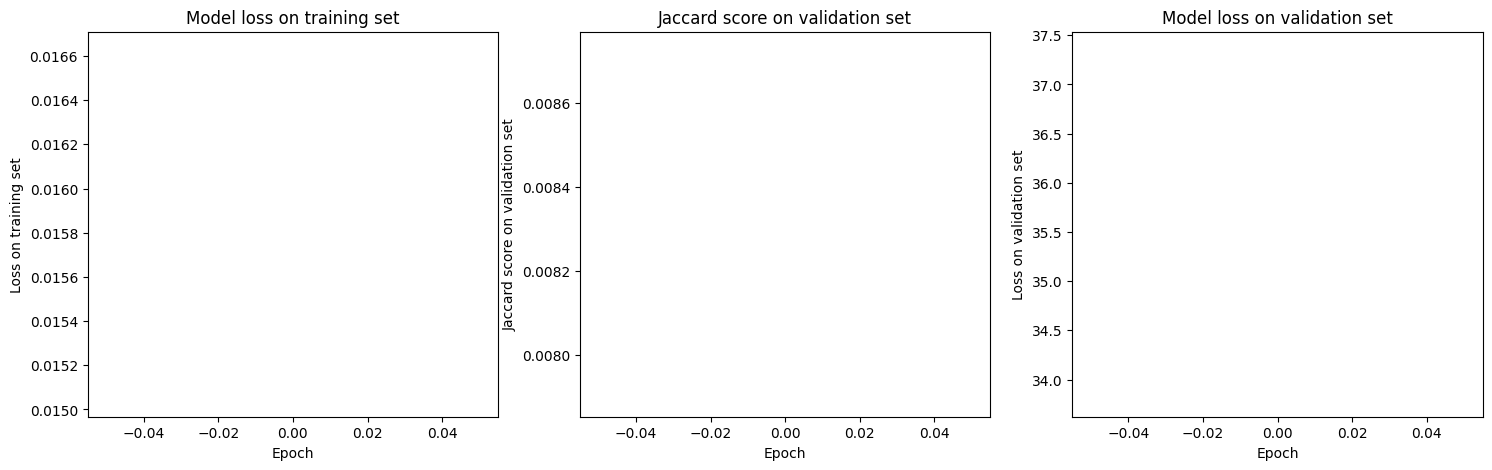

In [20]:
plot_performance(loss_list_train, loss_list_test, jac_score_list_test)

Accuracy on batch 0: 99.47%
Accuracy on batch 1: 99.50%
Accuracy on batch 2: 99.54%
Accuracy on batch 3: 99.46%
Accuracy on batch 4: 99.38%
Accuracy on batch 5: 99.57%


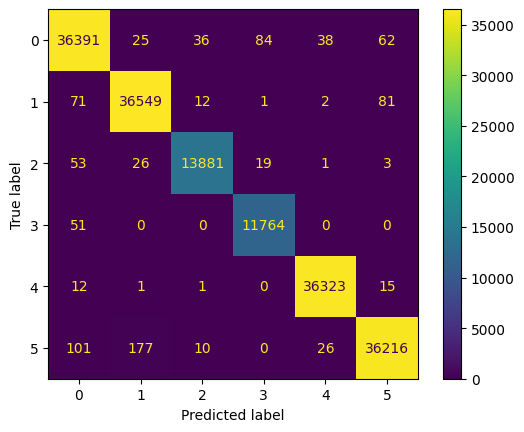

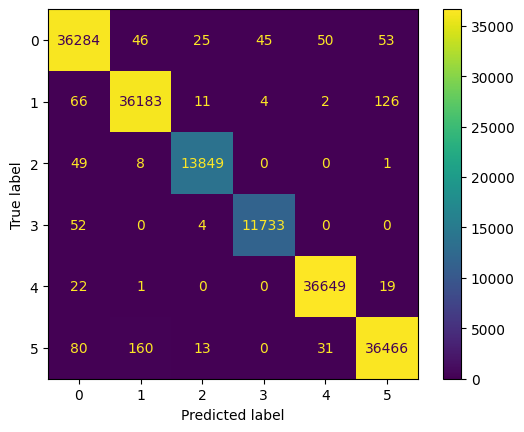

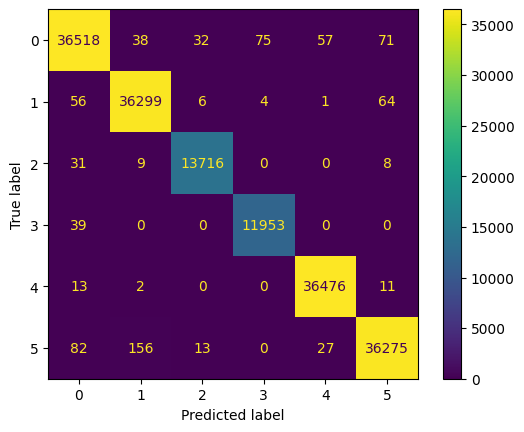

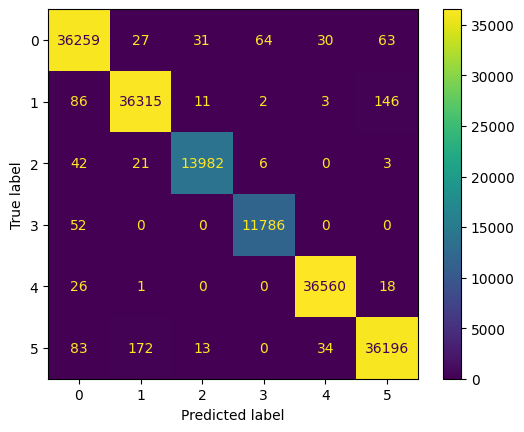

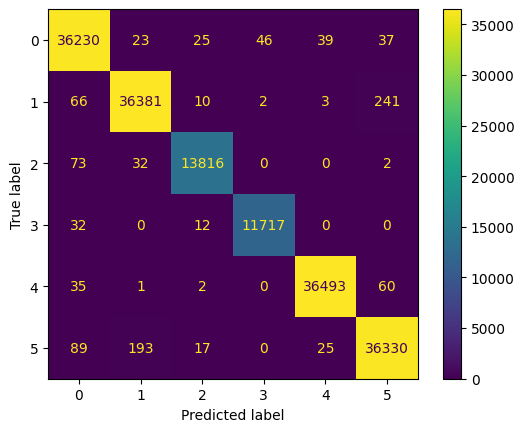

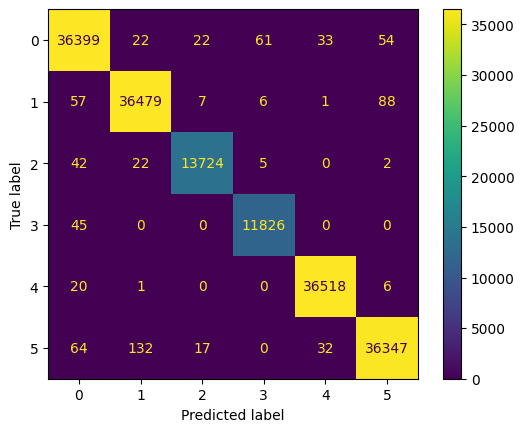

In [21]:
check_few_batches(model, train_dataloader)

In [22]:
# @title Saving the trained model {display-mode: "form"}

torch.save(
    model.state_dict(),
    f"submissions/model-{datetime.now().strftime('%Y_%m_%d-%H_%M')}.pth",
)

In [23]:
save_prediction(model, submission_set)

Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Size in memory of tensor arr_slice: 1.7619 MB
Time spent on slice 19: 48.30 seconds
Function save_prediction took 7.73 seconds